## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import display

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


    user_id - идентификатор пользователя, зашедшего на сайт
    date - дата захода
    group - группа теста (контрольная — А или тестовая — B)
    purchase - признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет)
    price - цена купленного тура (если покупка не состоялась, цена равна 0)

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
# приводим столбец date к тиму datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# группируме данные по группам A и B, и вычисляем минимум и максимум для каждой группы
display(data.groupby(['group'])['date'].min())
display(data.groupby(['group'])['date'].max())

group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]

group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]

**Ответ:** *A/B-тест проводился со 2 по 24 января 2021 года.*

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
# запрашиваем количество записей по значению группы
print(data['group'].value_counts())

# запрашиваем количество покупок в группе A
print('Количество покупок в группе A =', data[data['group'] == 'A']['purchase'].sum())
# запрашиваем количество покупок в группе B
print('Количество покупок в группе B =', data[data['group'] == 'B']['purchase'].sum())

# запрашиваем сумму по признаку price
print('Суммарное количество покупок составляет', round((data['price'].sum() / 1000000), 2), 'млн.руб.')
# запрашиваем сумму по признаку price В группе A
print('Суммарное количество покупок в группе A составляет', round((data[data['group'] == 'A']['price'].sum() / 1000000), 2), 'млн.руб.')
# запрашиваем сумму по признаку price в группе B
print('Суммарное количество покупок в угрппе B составляет', round((data[data['group'] == 'B']['price'].sum() / 1000000), 2), 'млн.руб.')

B    147276
A    147202
Name: group, dtype: int64
Количество покупок в группе A = 17723
Количество покупок в группе B = 17514
Суммарное количество покупок составляет 2990.36 млн.руб.
Суммарное количество покупок в группе A составляет 1436.26 млн.руб.
Суммарное количество покупок в угрппе B составляет 1554.1 млн.руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
# получаем уникальные значения id пользователей внутри групп
data_a = set(data[data['group'] == 'A']['user_id'])
data_b = set(data[data['group'] == 'B']['user_id'])
# вычисляем пересечения множеств
double_data = set.intersection(data_a, data_b)
print('Количество пользователей, попавших в обе группы =', len(double_data))

Количество пользователей, попавших в обе группы = 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

In [7]:
print('Количество наблюдений до очищения от дублей -', data.shape[0])
updated_data = data[data['user_id'].apply(lambda x: x not in double_data)]
print('Количество наблюдений после очищения от дублей -',updated_data.shape[0])

Количество наблюдений до очищения от дублей - 294478
Количество наблюдений после очищения от дублей - 290688


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица со столбцами: *group, count_visits, count_purchases, sum_p*

Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?

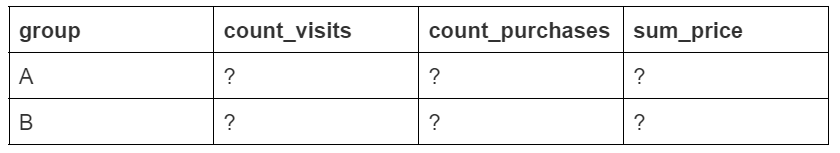

In [8]:
# группируем данные и переименовываем столбцы
grouped_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase': 'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

display(grouped_data)

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

*После очистки и группировки данных, можно сделать предварительный вывод (до статистических тестов), о том, **что группа 'B' активнее по количеству посещений сайта и сумме сделанных покупок**. Однако **группа 'A' выигрывает по количеству покупок**.*

*Это достаточно противоречивые показатели, основная цель любого бизнеса - извлечение прибыли, и тут группа 'B' кажется привлекательнее, но большее количество покупок в группе 'A' может говорить о том, что в будущем эти клиенты вернуться и принесут больше денег.*

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
grouped_data['conversion'] = grouped_data['count_purchases'] / grouped_data['count_visits'] * 100
grouped_data['mean_check'] = grouped_data['sum_price'] / grouped_data['count_purchases']
# выводим данные конверсии по каждой из групп
print('Конверсия в группе A составляет', round(grouped_data[grouped_data['group'] == 'A']['conversion'][0], 2), '%')
print('Конверсия в группе B составляет', round(grouped_data[grouped_data['group'] == 'B']['conversion'][1], 2), '%')
# выводим данные среднего чека по каждой из групп
print('Средний чек в группе A составляет', round(grouped_data[grouped_data['group'] == 'A']['mean_check'][0]), 'рублей')
print('Средний чек в группе B составляет', round(grouped_data[grouped_data['group'] == 'B']['mean_check'][1]), 'рублей')

Конверсия в группе A составляет 12.03 %
Конверсия в группе B составляет 11.89 %
Средний чек в группе A составляет 81076 рублей
Средний чек в группе B составляет 88665 рублей


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

*Вывод на данном этапе пока что совпадает с предыдущим, **группа 'B' эффективнее по среднему чеку, а группа 'A' выигрывает по конверсии**.*

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
data_pivot_purchase = updated_data[updated_data['price'] > 0].pivot_table(values='purchase', index='price', columns='group', aggfunc='count')
display(data_pivot_purchase)

group,A,B
price,,
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Зависимость количества продаж от цены и тестовой группы')

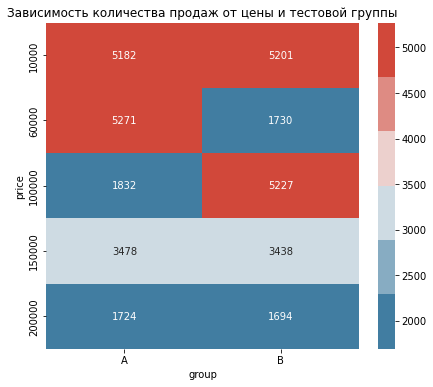

In [11]:
fig = plt.figure(figsize=(7, 6))
heatmap = sns.heatmap(data=data_pivot_purchase, annot = True, fmt = '', cmap=sns.diverging_palette(235, 15))
heatmap.set_title('Зависимость количества продаж от цены и тестовой группы')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

*Представители **группы 'A'** значительно чаще соверащют покупки в категории **60 000**, по сравнению с представителями **группы 'B'**. В группе **100 000** наблюдается обратная картина - представители **группы 'B'** чаще соверащют покупки по сравнению с представителями **группы 'A'**.*

*По остальным группам наблюдаются схожие показатели.*

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
# группируем данные и переименовываем столбцы
grouped_date_data = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase': 'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
# добавляем данные по ежедневной конверсии и среднем чеке
grouped_date_data['conversion'] = grouped_date_data['count_purchases'] / grouped_date_data['count_visits'] * 100
grouped_date_data['mean_check'] = grouped_date_data['sum_price'] / grouped_date_data['count_purchases']

# вычисляем конверсию в группах на 3 января 2021 года
conversion_a = grouped_date_data[(grouped_date_data['date'] == '2021-01-03') & (grouped_date_data['group'] == 'A')]['conversion']
print('Конвересия в группе A от 3 января 2021 года равна', round(conversion_a[2], 2), '%')
conversion_b = grouped_date_data[(grouped_date_data['date'] == '2021-01-03') & (grouped_date_data['group'] == 'B')]['conversion']
print('Конвересия в группе B от 3 января 2021 года равна', round(conversion_b[3], 2), '%')

# вычисляем средний чек в группах на 3 января 2021 года
mean_check_a = grouped_date_data[(grouped_date_data['date'] == '2021-01-03') & (grouped_date_data['group'] == 'A')]['mean_check']
print('Средний чек в группе A 3 января 2021 года равен', round(mean_check_a[2]), 'руб.')
mean_check_b = grouped_date_data[(grouped_date_data['date'] == '2021-01-03') & (grouped_date_data['group'] == 'B')]['mean_check']
print('Средний чек в группе B 3 января 2021 года равен', round(mean_check_b[3]), 'руб.')

Конвересия в группе A от 3 января 2021 года равна 11.34 %
Конвересия в группе B от 3 января 2021 года равна 11.39 %
Средний чек в группе A 3 января 2021 года равен 82888 руб.
Средний чек в группе B 3 января 2021 года равен 87480 руб.


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
# вычисляем кумулятивное количество посещений
grouped_date_data['cum_count_visits'] = grouped_date_data.groupby(['group'])['count_visits'].cumsum()
# вычисляем кумулятивное количество покупок
grouped_date_data['cum_count_purchases'] = grouped_date_data.groupby(['group'])['count_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок
grouped_date_data['cum_sum_price'] = grouped_date_data.groupby(['group'])['sum_price'].cumsum()

grouped_date_data['cum_conversion'] = grouped_date_data['cum_count_purchases'] / grouped_date_data['cum_count_visits'] * 100
grouped_date_data['cum_mean_check'] = grouped_date_data['cum_sum_price'] / grouped_date_data['cum_count_purchases']

# вычисляем кумулятивную конверсию в группе B на 20 января 2021 года
cum_conversion_b = grouped_date_data[(grouped_date_data['date'] == '2021-01-20') & (grouped_date_data['group'] == 'B')]['cum_conversion']
print('Кумулятивная конвересия в группе B от 20 января 2021 года равна', round(tuple(cum_conversion_b)[0], 2), '%')
# вычисляем кумулятивный средний чек в группе A на 12 января 2021 года
cum_mean_check_a = grouped_date_data[(grouped_date_data['date'] == '2021-01-12') & (grouped_date_data['group'] == 'A')]['cum_mean_check']
print('Кумулятивный средний чек в группе A 12 января 2021 года равен', round(tuple(cum_mean_check_a)[0]), 'руб.')

Кумулятивная конвересия в группе B от 20 января 2021 года равна 11.9 %
Кумулятивный средний чек в группе A 12 января 2021 года равен 81492 руб.


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

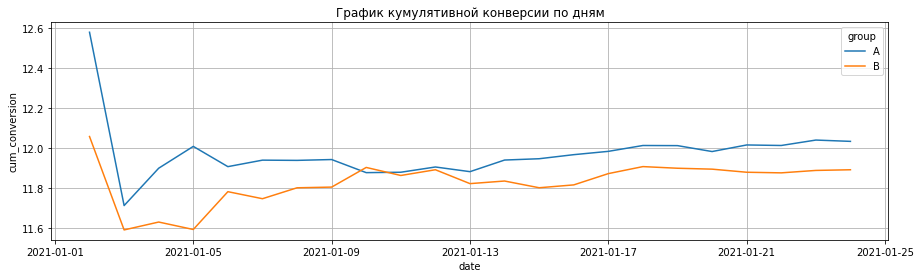

In [14]:
fig = plt.figure(figsize=(15, 4))
# строим lineplot для кумулятивной конверсии во времени в каждой группе
_ = sns.lineplot(x='date', y='cum_conversion', data=grouped_date_data, hue='group')

# задаём подпись к графику
_.set_title('График кумулятивной конверсии по дням')
# задаём отображение сетки
_.grid(True)

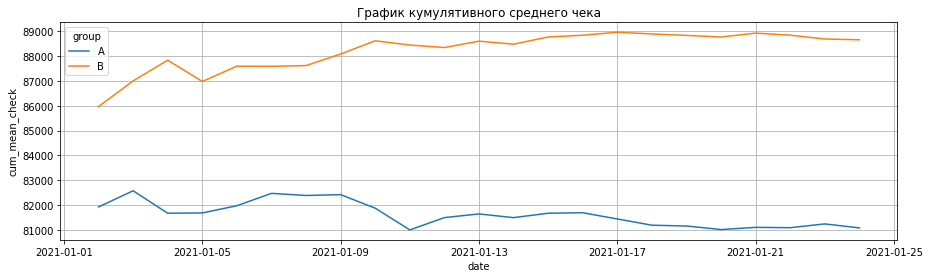

In [15]:
fig = plt.figure(figsize=(15, 4))
# строим lineplot для кумулятивной конверсии во времени в каждой группе
_ = sns.lineplot(x='date', y='cum_mean_check', data=grouped_date_data, hue='group')

# задаём подпись к графику
_.set_title('График кумулятивного среднего чека')
# задаём отображение сетки
_.grid(True)

*Начиная с 14 января, показатель кумулятивной конверсии стабилизируется, мы наблюдаем, что **в группе 'A' конверсия выше, чем в группе 'B'** в среднем **на 0.2 %**.*

*Разрыв в показателях среднего чек увеличивается с первого дня, относительно стабильно значения ведут себя начиная с 21 января. Показатель **в группе 'B' выше, чем в группе 'A'** в среднем **на 7-8 тысяч рублей**.*

*Складывается ощущение, что для получения более твёрдых выводов нужно продлить тестирование еще на несколько недель.*

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [16]:
# для проверки гипотезы равенства пропорций лучше использоввать z-тестом. 
# этот тест является наиболее популярным для задачи определения статистической значимости изменения конверсии.

H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости

# рассчитаем количество «успехов» - сумма по столбцу count_purchases таблицы grouped_data
# общее количество наблюдений - количество непустых значений в столбце purchase таблицы grouped_data
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(count=grouped_data['count_purchases'],
                               nobs=grouped_data['count_visits'],
                               alternative='larger'
                               )
print('p-value: ', round(p_value, 2))

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print(f'Отвергаем нулевую гипотезу, принимаем альтернативную гипотезу H1: {H1}')
else:
    print(f'Принимаем нулевую гипотезу: {H0}')

p-value:  0.12
Принимаем нулевую гипотезу: Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

*По результатам статистического теста (z-тест), полученное значение p-value больше уровня значимости, а это значит, что мы принимаем нулевую гипотезу, **конверсии в группах A и B можно считать равными**.*

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [17]:
# зададим функцию для вычисления доверительного интервала
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

# применим функцию к данным конверсии
conf_interval_a = proportions_conf_interval(
n=updated_data[updated_data['group'] == 'A']['purchase'].count(), # размер выборки
x_p=updated_data[updated_data['group'] == 'A']['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=updated_data[updated_data['group'] == 'A']['purchase'].count(), # размер выборки
x_p=updated_data[updated_data['group'] == 'B']['purchase'].mean() # выборочная пропорция
)
print(f'Доверительный интервал для конверсии группы А: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [18]:
# зададим функцию для вычисления доверительного интервала для разницы конверсий
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [updated_data[updated_data['group'] == 'A']['purchase'].count(), updated_data[updated_data['group'] == 'B']['purchase'].count()]
# выборочная пропорция групп A и B
xp = [updated_data[updated_data['group'] == 'A']['purchase'].mean(), updated_data[updated_data['group'] == 'B']['purchase'].mean()]

# применим функцию к данным конверсии
diff_inverval = diff_proportions_conf_interval(n, xp)
print(f'Доверительный интервал для разности конверсий: {diff_inverval}')

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %. То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. 

*Отсюда можно сделать вывод, что статистической **разницы в конверсии между вариантами А и B не существует**, то есть они являются равнозначными по данной метрике.*

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [19]:
# для проверки нормальности распределения ежедневного среднего чека воспользуемся тестом Шапиро-Уилка
H0 = 'Распределения в обеих группах нормальные.'
H1 = 'Распределение в одной или обеих группах отлично от нормального.'
alpha = 0.05 # уровень значимости

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(grouped_date_data[grouped_date_data['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(grouped_date_data[grouped_date_data['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу, принимаем альтернативную гипотезу H1: {H1}')
else:
    print(f'Принимаем нулевую гипотезу: {H0}')

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу: Распределения в обеих группах нормальные.


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [20]:
# так как данные распределены нормально, у нас две группы, а количество наблюдений меньше 30
# то для проверки статистической значимости нужно использовать T-тест
H0 = 'Ежедневный средний чек в группах А и B равный'
H1 = 'Ежедневный средний чек в групее А меньше, чем ежедневный средний чек  в группе B'
alpha = 0.05 # уровень значимости

# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=grouped_date_data[grouped_date_data['group'] == 'A']['mean_check'],
    b=grouped_date_data[grouped_date_data['group'] == 'B']['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue < alpha: 
    print(f'Отвергаем нулевую гипотезу, принимаем альтернативную гипотезу H1: {H1}')
else:
    print(f'Принимаем нулевую гипотезу: {H0}')

p-value: 0.0
Отвергаем нулевую гипотезу, принимаем альтернативную гипотезу H1: Ежедневный средний чек в групее А меньше, чем ежедневный средний чек  в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

*Статистический тест подтверждает ранее полученные данные по среднему чек. **В группе 'B' средний чек больше, чем в группе 'A'**.*

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [21]:
# зададим функцию для вычисления доверительного интервала
def conf_interval_t(n, x_mean, x_std, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, n - 1) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return round(lower_bound), round(upper_bound)

# применим функцию к данным по среднему чеку
conf_interval_a = conf_interval_t(n = grouped_date_data[grouped_date_data['group'] == 'A']['mean_check'].count(), # размер выборки
                                  x_mean = grouped_date_data[grouped_date_data['group'] == 'A']['mean_check'].mean(), # выборочное среднее
                                  x_std = grouped_date_data[grouped_date_data['group'] == 'A']['mean_check'].std() # выборочное стандартное отклонение
                                  )

conf_interval_b = conf_interval_t(n = grouped_date_data[grouped_date_data['group'] == 'B']['mean_check'].count(), # размер выборки
                                  x_mean = grouped_date_data[grouped_date_data['group'] == 'B']['mean_check'].mean(), # выборочное среднее
                                  x_std = grouped_date_data[grouped_date_data['group'] == 'B']['mean_check'].std() # выборочное стандартное отклонение
                                  )

print(f'Доверительный интервал для конверсии группы А: {conf_interval_a}')
print(f'Доверительный интервал для конверсии группы B: {conf_interval_b}')

Доверительный интервал для конверсии группы А: (79630, 82308)
Доверительный интервал для конверсии группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

*Пересечений между доверительными интервалами знаачений среднего чек группы 'A' и группы 'B' нет. Судя по доверительным интервалам, **средний чек в группе 'B' значительно выше среднего чек в группе 'A'**.*

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

*По результатам A/B-тестирования можно сделать вывод, что **дизайн посадочной страницы группы 'B' предпочтительнее**, так как **средний чек в группе 'B' выше среднего чек в группе 'A'**, при этом значимой разницы между конверсиями в группах нет. Значит бизнес извлечёт бОльшую прибыль используя вариант дизайна, протестированный в группе 'B'.*